# Введение в искусственные нейронные сети
# Урок 5. Рекуррентные нейронные сети

# Разбор урока

## Построение сети LSTM для оценки отзывов IMDB

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb

In [ ]:
max_features = 16000

# обрезание текстов после данного количества слов (среди top max_features наиболее используемые слова)
maxlen = 80

print('Загрузка данных...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'тренировочные последовательности')
print(len(x_test), 'тестовые последовательности')

print('Pad последовательности (примеров в x единицу времени)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Загрузка данных...


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the nda

25000 тренировочные последовательности
25000 тестовые последовательности
Pad последовательности (примеров в x единицу времени)
x_train shape: (25000, 80)
x_test shape: (25000, 80)


In [ ]:
# https://keras.io/examples/nlp/bidirectional_lstm_imdb/

print('Построение модели...')
model = Sequential()

model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))

model.add(Dense(1, activation='sigmoid'))

# стоит попробовать использовать другие оптимайзер и другие конфигурации оптимайзеров 
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


Построение модели...


In [ ]:
batch_size = 50 # увеличьте значение для ускорения обучения

print('Процесс обучения...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=1, # увеличьте при необходимости
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Результат при тестировании:', score)
print('Тестовая точность:', acc)

Процесс обучения...
500/500 [==============================] - 10s 21ms/step - loss: 0.3758 - accuracy: 0.8352
Результат при тестировании: 0.37578505277633667
Тестовая точность: 0.8352400064468384


## Построение сети GRU на тексте Алиса в стране чудес

Давайте также посмотрим пример в которм будет использоваться другой класс задач - генерация текста на основе тренировочного текста. В задачу нейросети будет входить:
* обучившись на тексте Алиса в стране чудес, начать генерировать текст, похожий на тот, что можно встретить в этой книге. 
* Также в этом примере будет использоваться GRU.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from keras.layers import Dense, Activation
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras.models import Sequential


# построчное чтение из примера с текстом 
with open('/content/drive/My Drive/Colab Notebooks/114_Neuronets/less_05/alice_in_wonderland.txt', 'rb') as _in:
    lines = []
    for line in _in:
        line = line.strip().lower().decode("ascii", "ignore")
        if len(line) == 0:
            continue
        lines.append(line)
text = " ".join(lines)
chars = set([c for c in text])
nb_chars = len(chars)


# создание индекса символов и reverse mapping чтобы передвигаться между значениями numerical
# ID and a specific character. The numerical ID will correspond to a column
# ID и определенный символ. Numerical ID будет соответсвовать колонке
# число при использовании one-hot кодировки для представление входов символов
char2index = {c: i for i, c in enumerate(chars)}
index2char = {i: c for i, c in enumerate(chars)}

# для удобства выберете фиксированную длину последовательность 10 символов 
SEQLEN, STEP = 10, 1
input_chars, label_chars = [], []

# конвертация data в серии разных SEQLEN-length субпоследовательностей
for i in range(0, len(text) - SEQLEN, STEP):
    input_chars.append(text[i: i + SEQLEN])
    label_chars.append(text[i + SEQLEN])


# Вычисление one-hot encoding входных последовательностей X и следующего символа (the label) y

X = np.zeros((len(input_chars), SEQLEN, nb_chars), dtype=np.bool)
y = np.zeros((len(input_chars), nb_chars), dtype=np.bool)
for i, input_char in enumerate(input_chars):
    for j, ch in enumerate(input_char):
        X[i, j, char2index[ch]] = 1
    y[i, char2index[label_chars[i]]] = 1


# установка ряда метапамертров  для нейронной сети и процесса тренировки
BATCH_SIZE, HIDDEN_SIZE = 128, 128
NUM_ITERATIONS = 25 # 25 должно быть достаточно
NUM_EPOCHS_PER_ITERATION = 1
NUM_PREDS_PER_EPOCH = 100


# Create a super simple recurrent neural network. There is one recurrent
# layer that produces an embedding of size HIDDEN_SIZE from the one-hot
# encoded input layer. This is followed by a Dense fully-connected layer
# across the set of possible next characters, which is converted to a
# probability score via a standard softmax activation with a multi-class
# cross-entropy loss function linking the prediction to the one-hot
# encoding character label.

'''
Создание очень простой рекуррентной нейронной сети. В ней будет один реккурентный закодированный входной слой. За ним последует полносвязный слой связанный с набором возможных следующих символов, которые конвертированы в вероятностные результаты через стандартную softmax активацию с multi-class cross-encoding loss функцию ссылающуются на предсказание one-hot encoding лейбл символа
'''

model = Sequential()
model.add(
    GRU(  # вы можете изменить эту часть на LSTM или SimpleRNN, чтобы попробовать альтернативы
        HIDDEN_SIZE,
        return_sequences=False,
        input_shape=(SEQLEN, nb_chars),
        unroll=True
    )
)
model.add(Dense(nb_chars))
model.add(Activation("softmax"))
model.compile(loss="categorical_crossentropy", optimizer="rmsprop")


# выполнение серий тренировочных и демонстрационных итераций 
for iteration in range(NUM_ITERATIONS):

    # для каждой итерации запуск передачи данных в модель 
    print("=" * 50)
    print("Итерация #: %d" % (iteration))
    model.fit(X, y, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS_PER_ITERATION)

    # Select a random example input sequence.
    test_idx = np.random.randint(len(input_chars))
    test_chars = input_chars[test_idx]

    # для числа шагов предсказаний использование текущей тренируемой модели 
    # конструирование one-hot encoding для тестирования input и добавление предсказания.
    print("Генерация из посева: %s" % (test_chars))
    print(test_chars, end="")
    for i in range(NUM_PREDS_PER_EPOCH):

        # здесь one-hot encoding.
        X_test = np.zeros((1, SEQLEN, nb_chars))
        for j, ch in enumerate(test_chars):
            X_test[0, j, char2index[ch]] = 1

        # осуществление предсказания с помощью текущей модели.
        pred = model.predict(X_test, verbose=0)[0]
        y_pred = index2char[np.argmax(pred)]

        # вывод предсказания добавленного к тестовому примеру 
        print(y_pred, end="")

        # инкрементация тестового примера содержащего предсказание
        test_chars = test_chars[1:] + y_pred
print()


Итерация #: 0
1241/1241 [==============================] - 18s 8ms/step - loss: 2.6007
Генерация из посева:  impatient
 impatient the was the was the was the was the was the was the was the was the was the was the was the was the==================================================
Итерация #: 1
1241/1241 [==============================] - 10s 8ms/step - loss: 1.9104
Генерация из посева: seemed qui
seemed quite the said the could the said the could the said the could the said the could the said the could th==================================================
Итерация #: 2
1241/1241 [==============================] - 10s 8ms/step - loss: 1.7575
Генерация из посева: tle boy, a
tle boy, and the course the course the course the course the course the course the course the course the cours==================================================
Итерация #: 3
1241/1241 [==============================] - 10s 8ms/step - loss: 1.6584
Генерация из посева: pose so, s
pose so, so she said the morsel to hersel

# Задание 1
Попробуйте обучить нейронную сеть LSTM на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний). 

Опишите, какой результата вы получили? 

Что помогло вам улучшить ее точность?

## Решение
Пострим нейронную сеть LSTM на тексте Алиса в стране чудес на английском языке

### Читаем библиотеки

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

### 1.1 LSTM с длиной словаря 10000, шириной слоя LSTM 10

In [ ]:
data = open('/content/drive/My Drive/Colab Notebooks/114_Neuronets/less_05/alice_in_wonderland.txt').read()
#Читаем текст
corpus = data.lower().split("\n")

In [ ]:
corpus[:10]

['project gutenberg’s alice’s adventures in wonderland, by lewis carroll',
 '',
 'this ebook is for the use of anyone anywhere at no cost and with',
 'almost no restrictions whatsoever.  you may copy it, give it away or',
 're-use it under the terms of the project gutenberg license included',
 'with this ebook or online at www.gutenberg.org',
 '',
 '',
 'title: alice’s adventures in wonderland',
 '']

#### Исполним токенизацию и кодирование

In [ ]:
# Создаем объект для токенизации
tokenizer1 = Tokenizer( num_words=10000)

tokenizer1.fit_on_texts(corpus)
total_words = len(tokenizer1.word_index) + 1  # +1 для символа, который заменяет неизвестные слова

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer1.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [ ]:
token_list

[3397, 4, 367, 1307, 3398, 4, 278, 38, 497, 622]

In [ ]:
tokenizer1.index_word[10]

'in'

In [ ]:
tokenizer1.word_index['little']

32

In [ ]:
input_sequences[11:15,:]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         22, 444,  31,  24,   1],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  22,
        444,  31,  24,   1, 150],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  22, 444,
         31,  24,   1, 150,   6],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  22, 444,  31,
         24,   1, 150,   6, 707]], dtype=int32)

In [ ]:
label.shape

(28231, 3399)

#### Создаем сеть

In [ ]:
callback = EarlyStopping(monitor='val_accuracy', patience=5) # создаем обратный вызов - callback - тут "Ранний останов"

In [ ]:
model1 = Sequential()
model1.add(Embedding(total_words, 10, input_length=max_sequence_len-1))  # вложение тренируемое для перехода от слова к его векторному коду 
# на вход вложения (эмбединга) передаем вектор словарь (длина равна словарю, вектор разреженный)), на выход строим вектор из n (тут 10) координат - он плотный

model1.add(LSTM(10))
model1.add(Dropout( 0.2))
model1.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model1.add(Dense(total_words, activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model1.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 17, 10)            33990     
_________________________________________________________________
lstm_12 (LSTM)               (None, 10)                840       
_________________________________________________________________
dropout_12 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 1699)              18689     
_________________________________________________________________
dense_25 (Dense)             (None, 3399)              5778300   
Total params: 5,831,819
Trainable params: 5,831,819
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history1 = model1.fit(predictors, label, epochs=100, validation_split=0.2, callbacks=[callback],verbose=1)

Epoch 1/100
706/706 [==============================] - 7s 8ms/step - loss: 6.3294 - accuracy: 0.0548 - val_loss: 7.1524 - val_accuracy: 0.0719
Epoch 2/100
706/706 [==============================] - 5s 7ms/step - loss: 5.9414 - accuracy: 0.0553 - val_loss: 7.3440 - val_accuracy: 0.0554
Epoch 3/100
706/706 [==============================] - 5s 7ms/step - loss: 5.8142 - accuracy: 0.0564 - val_loss: 7.4106 - val_accuracy: 0.0489
Epoch 4/100
706/706 [==============================] - 5s 7ms/step - loss: 5.7071 - accuracy: 0.0627 - val_loss: 7.5020 - val_accuracy: 0.0586
Epoch 5/100
706/706 [==============================] - 5s 7ms/step - loss: 5.6158 - accuracy: 0.0734 - val_loss: 7.6192 - val_accuracy: 0.0735
Epoch 6/100
706/706 [==============================] - 5s 7ms/step - loss: 5.5258 - accuracy: 0.0850 - val_loss: 7.7561 - val_accuracy: 0.0783
Epoch 7/100
706/706 [==============================] - 5s 7ms/step - loss: 5.4393 - accuracy: 0.0912 - val_loss: 7.8529 - val_accuracy: 0.0712

#### Тест

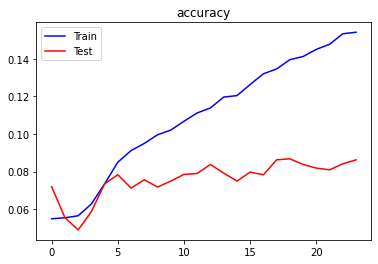

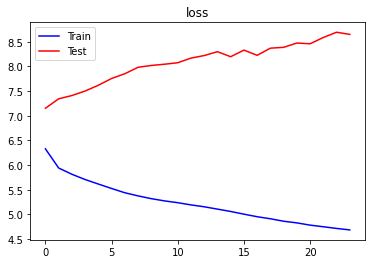

In [ ]:
import matplotlib.pyplot as plt
acc = history1.history['accuracy']
acc_v = history1.history['val_accuracy']
loss = history1.history['loss']
loss_v = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Train')
plt.plot(epochs, acc_v, 'r', label='Test')
plt.legend()
plt.title('accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Train')
plt.plot(epochs, loss_v, 'r', label='Test')
plt.title('loss')
plt.legend()

plt.show()

In [ ]:
seed_text = "For a minute or two she stood looking at the house"

next_words = 10
  
for _ in range(next_words):
	token_list = tokenizer1.texts_to_sequences([seed_text])[0]
	print(token_list)
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model1.predict_classes(token_list, verbose=0)
  #y_p=model.predict(token_list)
	output_word = ""
	y_p=model1.predict(token_list)
	for word, index in tokenizer1.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

[24, 5, 216, 27, 135, 7, 596, 149, 19, 1, 240]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[24, 5, 216, 27, 135, 7, 596, 149, 19, 1, 240, 3]
[24, 5, 216, 27, 135, 7, 596, 149, 19, 1, 240, 3, 7]
[24, 5, 216, 27, 135, 7, 596, 149, 19, 1, 240, 3, 7, 13]
[24, 5, 216, 27, 135, 7, 596, 149, 19, 1, 240, 3, 7, 13, 5]
[24, 5, 216, 27, 135, 7, 596, 149, 19, 1, 240, 3, 7, 13, 5, 32]
[24, 5, 216, 27, 135, 7, 596, 149, 19, 1, 240, 3, 7, 13, 5, 32, 32]
[24, 5, 216, 27, 135, 7, 596, 149, 19, 1, 240, 3, 7, 13, 5, 32, 32, 32]
[24, 5, 216, 27, 135, 7, 596, 149, 19, 1, 240, 3, 7, 13, 5, 32, 32, 32, 32]
[24, 5, 216, 27, 135, 7, 596, 149, 19, 1, 240, 3, 7, 13, 5, 32, 32, 32, 32, 32]
For a minute or two she stood looking at the house and she was a little little little little little little


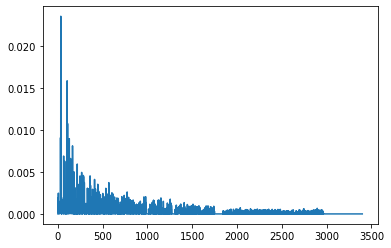

In [ ]:
plt.plot(y_p[0,:])

In [ ]:
ind_prob=np.where(y_p[0,:]>0.00660)[0]
ind_prob

array([ 29,  32,  64, 103, 104, 108, 127, 141, 163])

In [ ]:
for i,ind in enumerate(ind_prob.tolist()):
  print(tokenizer1.index_word[ind], ' : ', y_p[0,i])

very  :  8.109457e-09
little  :  0.0018767244
time  :  0.00017113452
head  :  0.0005868065
thing  :  0.0007998441
voice  :  0.002475591
great  :  0.000113974354
large  :  0.0011730676
eyes  :  0.00016286153


### 1.2 LSTM с длиной словаря 10000, шириной слоя LSTM 256

#### Создаем сеть

In [ ]:
model4 = Sequential()
model4.add(Embedding(total_words, 10, input_length=max_sequence_len-1))  # вложение тренируемое для перехода от слова к его векторному коду 
# на вход вложения (эмбединга) передаем вектор словарь (длина равна словарю, вектор разреженный)), на выход строим вектор из n (тут 10) координат - он плотный

model4.add(LSTM(256))
model4.add(Dropout( 0.2))
model4.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model4.add(Dense(total_words, activation='softmax'))
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model4.summary())

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 17, 10)            33990     
_________________________________________________________________
lstm_16 (LSTM)               (None, 256)               273408    
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 1699)              436643    
_________________________________________________________________
dense_33 (Dense)             (None, 3399)              5778300   
Total params: 6,522,341
Trainable params: 6,522,341
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history4 = model4.fit(predictors, label, epochs=100, validation_split=0.2, callbacks=[callback],verbose=1)

Epoch 1/100
706/706 [==============================] - 7s 8ms/step - loss: 6.3666 - accuracy: 0.0535 - val_loss: 6.9251 - val_accuracy: 0.0719
Epoch 2/100
706/706 [==============================] - 5s 7ms/step - loss: 5.9138 - accuracy: 0.0571 - val_loss: 7.1518 - val_accuracy: 0.0669
Epoch 3/100
706/706 [==============================] - 5s 7ms/step - loss: 5.7372 - accuracy: 0.0667 - val_loss: 7.2123 - val_accuracy: 0.0832
Epoch 4/100
706/706 [==============================] - 5s 7ms/step - loss: 5.5914 - accuracy: 0.0777 - val_loss: 7.4770 - val_accuracy: 0.0825
Epoch 5/100
706/706 [==============================] - 5s 7ms/step - loss: 5.4847 - accuracy: 0.0827 - val_loss: 7.6217 - val_accuracy: 0.0829
Epoch 6/100
706/706 [==============================] - 5s 7ms/step - loss: 5.3753 - accuracy: 0.0948 - val_loss: 7.6731 - val_accuracy: 0.0884
Epoch 7/100
706/706 [==============================] - 5s 7ms/step - loss: 5.2463 - accuracy: 0.1086 - val_loss: 7.7507 - val_accuracy: 0.0877

#### Тест

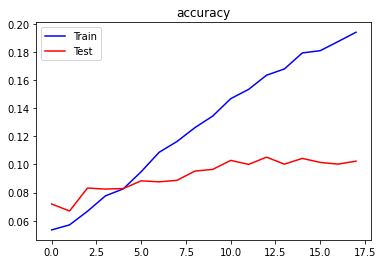

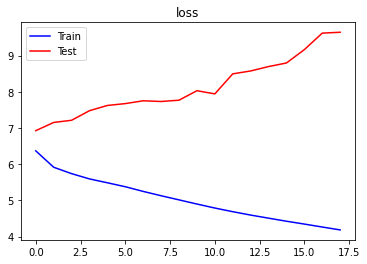

In [ ]:
import matplotlib.pyplot as plt
acc = history4.history['accuracy']
acc_v = history4.history['val_accuracy']
loss = history4.history['loss']
loss_v = history4.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Train')
plt.plot(epochs, acc_v, 'r', label='Test')
plt.legend()
plt.title('accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Train')
plt.plot(epochs, loss_v, 'r', label='Test')
plt.title('loss')
plt.legend()

plt.show()

In [ ]:
seed_text = "For a minute or two she stood looking at the house"
#seed_text = "She is my girl, I see in my hend"
next_words = 10
  
for _ in range(next_words):
	token_list = tokenizer1.texts_to_sequences([seed_text])[0]
	print(token_list)
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model4.predict_classes(token_list, verbose=0)
  #y_p=model.predict(token_list)
	output_word = ""
	y_p=model4.predict(token_list)
	for word, index in tokenizer1.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

[24, 5, 216, 27, 135, 7, 596, 149, 19, 1, 240]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[24, 5, 216, 27, 135, 7, 596, 149, 19, 1, 240, 3]
[24, 5, 216, 27, 135, 7, 596, 149, 19, 1, 240, 3, 7]
[24, 5, 216, 27, 135, 7, 596, 149, 19, 1, 240, 3, 7, 13]
[24, 5, 216, 27, 135, 7, 596, 149, 19, 1, 240, 3, 7, 13, 5]
[24, 5, 216, 27, 135, 7, 596, 149, 19, 1, 240, 3, 7, 13, 5, 32]
[24, 5, 216, 27, 135, 7, 596, 149, 19, 1, 240, 3, 7, 13, 5, 32, 359]
[24, 5, 216, 27, 135, 7, 596, 149, 19, 1, 240, 3, 7, 13, 5, 32, 359, 4]
[24, 5, 216, 27, 135, 7, 596, 149, 19, 1, 240, 3, 7, 13, 5, 32, 359, 4, 25]
[24, 5, 216, 27, 135, 7, 596, 149, 19, 1, 240, 3, 7, 13, 5, 32, 359, 4, 25, 4]
For a minute or two she stood looking at the house and she was a little deal to be to be


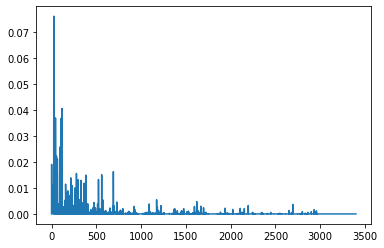

In [ ]:
plt.plot(y_p[0,:])

In [ ]:
ind_prob=np.where(y_p[0,:]>0.01500)[0]
ind_prob

array([  1,  25,  44,  55,  65,  91,  95, 106, 116, 278, 560, 690])

In [ ]:
for i,ind in enumerate(ind_prob.tolist()):
  print(tokenizer1.index_word[ind], ' : ', y_p[0,i])

the  :  5.5856934e-11
be  :  0.01904393
do  :  0.0016519458
have  :  0.00029663305
see  :  0.0013618562
think  :  0.01106781
say  :  0.00023701627
go  :  0.00046007114
get  :  0.0026808172
hear  :  0.00015695652
listen  :  0.00060242973
sing  :  0.00074417004


### 1.3 LSTM с длиной словаря 300, шириной слоя LSTM 10

In [ ]:
data = open('/content/drive/My Drive/Colab Notebooks/114_Neuronets/less_05/alice_in_wonderland.txt').read()
#Читаем текст
corpus = data.lower().split("\n")

#### Исполним токенизацию и кодирование

In [ ]:
# Создаем объект для токенизации
tokenizer2 = Tokenizer( num_words=300)

tokenizer2.fit_on_texts(corpus)
total_words = len(tokenizer2.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer2.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [ ]:
label.shape

(19845, 3399)

#### Создаем сеть

In [ ]:
callback = EarlyStopping(monitor='val_accuracy', patience=5) # создаем обратный вызов - calback - тут "Ранний останов"

In [ ]:
model2 = Sequential()
model2.add(Embedding(total_words, 10, input_length=max_sequence_len-1))  # вложение тренируемое для перехода от слова к его векторному коду 
# на вход вложения (эмбединга) передаем вектор словарь (длина равна словарю, вектор разреженный)), на выход строим вектор из n (тут 10) координат - он плотный
#model.add(Bidirectional(LSTM(50, return_sequences = True)))

model2.add(LSTM(10))
model2.add(Dropout( 0.2))
model2.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model2.add(Dense(total_words, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 16, 10)            33990     
_________________________________________________________________
lstm_8 (LSTM)                (None, 10)                840       
_________________________________________________________________
dropout_8 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1699)              18689     
_________________________________________________________________
dense_17 (Dense)             (None, 3399)              5778300   
Total params: 5,831,819
Trainable params: 5,831,819
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history2 = model2.fit(predictors, label, epochs=100, validation_split=0.2, callbacks=[callback],verbose=1)

Epoch 1/100
497/497 [==============================] - 5s 8ms/step - loss: 5.1587 - accuracy: 0.0714 - val_loss: 5.3083 - val_accuracy: 0.1101
Epoch 2/100
497/497 [==============================] - 3s 7ms/step - loss: 4.8141 - accuracy: 0.0760 - val_loss: 5.2296 - val_accuracy: 0.0970
Epoch 3/100
497/497 [==============================] - 3s 7ms/step - loss: 4.7109 - accuracy: 0.0877 - val_loss: 5.1794 - val_accuracy: 0.1066
Epoch 4/100
497/497 [==============================] - 3s 7ms/step - loss: 4.6336 - accuracy: 0.0954 - val_loss: 5.1386 - val_accuracy: 0.1116
Epoch 5/100
497/497 [==============================] - 3s 7ms/step - loss: 4.5930 - accuracy: 0.0988 - val_loss: 5.1470 - val_accuracy: 0.1272
Epoch 6/100
497/497 [==============================] - 3s 7ms/step - loss: 4.5628 - accuracy: 0.1013 - val_loss: 5.1184 - val_accuracy: 0.1333
Epoch 7/100
497/497 [==============================] - 3s 7ms/step - loss: 4.5397 - accuracy: 0.1061 - val_loss: 5.1127 - val_accuracy: 0.1411

#### Тест

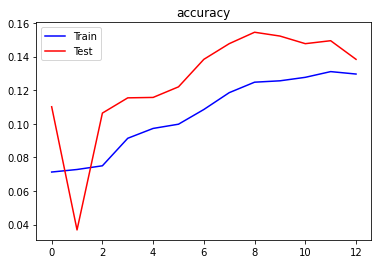

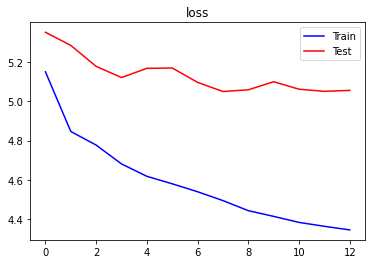

In [ ]:
import matplotlib.pyplot as plt
acc = history2.history['accuracy']
acc_v = history2.history['val_accuracy']
loss = history2.history['loss']
loss_v = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Train')
plt.plot(epochs, acc_v, 'r', label='Test')
plt.legend()
plt.title('accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Train')
plt.plot(epochs, loss_v, 'r', label='Test')
plt.title('loss')
plt.legend()

plt.show()

In [ ]:
seed_text = "For a minute or two she stood looking at the house"
#seed_text = "She is my girl, I see in my hend"
next_words = 10
  
for _ in range(next_words):
	token_list = tokenizer2.texts_to_sequences([seed_text])[0]
	print(token_list)
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model2.predict_classes(token_list, verbose=0)
  #y_p=model.predict(token_list)
	output_word = ""
	y_p=model2.predict(token_list)
	for word, index in tokenizer2.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

[24, 5, 216, 27, 135, 7, 149, 19, 1, 240]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[24, 5, 216, 27, 135, 7, 149, 19, 1, 240, 3]
[24, 5, 216, 27, 135, 7, 149, 19, 1, 240, 3, 1]
[24, 5, 216, 27, 135, 7, 149, 19, 1, 240, 3, 1, 81]
[24, 5, 216, 27, 135, 7, 149, 19, 1, 240, 3, 1, 81, 82]
[24, 5, 216, 27, 135, 7, 149, 19, 1, 240, 3, 1, 81, 82, 3]
[24, 5, 216, 27, 135, 7, 149, 19, 1, 240, 3, 1, 81, 82, 3, 7]
[24, 5, 216, 27, 135, 7, 149, 19, 1, 240, 3, 1, 81, 82, 3, 7, 13]
[24, 5, 216, 27, 135, 7, 149, 19, 1, 240, 3, 1, 81, 82, 3, 7, 13, 1]
[24, 5, 216, 27, 135, 7, 149, 19, 1, 240, 3, 1, 81, 82, 3, 7, 13, 1, 6]
For a minute or two she stood looking at the house and the mock turtle and she was the of the


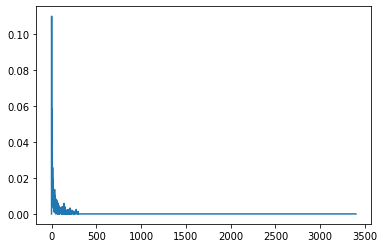

In [ ]:
plt.plot(y_p[0,:])

In [ ]:
ind_prob=np.where(y_p[0,:]>0.01500)[0]
ind_prob

array([ 1,  2,  3,  4,  5,  7,  8, 10, 12, 17, 19])

In [ ]:
for i,ind in enumerate(ind_prob.tolist()):
  print(tokenizer2.index_word[ind], ' : ', y_p[0,i])

the  :  6.24861e-08
’  :  0.11013052
and  :  0.015422518
to  :  0.05489064
a  :  0.041012153
she  :  0.042384386
it  :  0.0059562637
in  :  0.05836439
alice  :  0.03542117
her  :  0.013648514
at  :  0.019534549


### 1.4 LSTM с длиной словаря 100000, шириной слоя LSTM 10

In [ ]:
data = open('/content/drive/My Drive/Colab Notebooks/114_Neuronets/less_05/alice_in_wonderland.txt').read()
#Читаем текст
corpus = data.lower().split("\n")

In [ ]:
# Создаем объект для токенизации
tokenizer3 = Tokenizer( num_words=100000)

tokenizer3.fit_on_texts(corpus)
total_words = len(tokenizer3.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer3.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [ ]:
label.shape

(28231, 3399)

#### Создаем сеть

In [ ]:
callback = EarlyStopping(monitor='val_accuracy', patience=5) # создаем обратный вызов - calback - тут "Ранний останов"

In [ ]:
model3 = Sequential()
model3.add(Embedding(total_words, 10, input_length=max_sequence_len-1))  # вложение тренируемое для перехода от слова к его векторному коду 
# на вход вложения (эмбединга) передаем вектор словарь (длина равна словарю, вектор разреженный)), на выход строим вектор из n (тут 10) координат - он плотный
#model.add(Bidirectional(LSTM(50, return_sequences = True)))

model3.add(LSTM(10))
model3.add(Dropout( 0.2))
model3.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model3.add(Dense(total_words, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model3.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 17, 10)            33990     
_________________________________________________________________
lstm_4 (LSTM)                (None, 10)                840       
_________________________________________________________________
dropout_4 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1699)              18689     
_________________________________________________________________
dense_9 (Dense)              (None, 3399)              5778300   
Total params: 5,831,819
Trainable params: 5,831,819
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history3 = model3.fit(predictors, label, epochs=100, validation_split=0.2, callbacks=[callback],verbose=1)

Epoch 1/100
706/706 [==============================] - 7s 7ms/step - loss: 6.3309 - accuracy: 0.0549 - val_loss: 7.1034 - val_accuracy: 0.0719
Epoch 2/100
706/706 [==============================] - 5s 7ms/step - loss: 5.9429 - accuracy: 0.0559 - val_loss: 7.2967 - val_accuracy: 0.0714
Epoch 3/100
706/706 [==============================] - 5s 7ms/step - loss: 5.8160 - accuracy: 0.0592 - val_loss: 7.5462 - val_accuracy: 0.0487
Epoch 4/100
706/706 [==============================] - 5s 7ms/step - loss: 5.7051 - accuracy: 0.0698 - val_loss: 7.5686 - val_accuracy: 0.0687
Epoch 5/100
706/706 [==============================] - 5s 7ms/step - loss: 5.5975 - accuracy: 0.0836 - val_loss: 7.5584 - val_accuracy: 0.0813
Epoch 6/100
706/706 [==============================] - 5s 7ms/step - loss: 5.5018 - accuracy: 0.0930 - val_loss: 7.7494 - val_accuracy: 0.0767


#### Тест

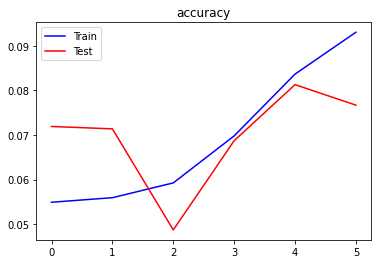

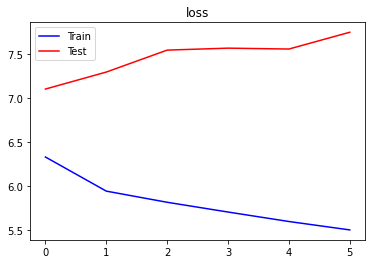

In [ ]:
import matplotlib.pyplot as plt
acc = history3.history['accuracy']
acc_v = history3.history['val_accuracy']
loss = history3.history['loss']
loss_v = history3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Train')
plt.plot(epochs, acc_v, 'r', label='Test')
plt.legend()
plt.title('accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Train')
plt.plot(epochs, loss_v, 'r', label='Test')
plt.title('loss')
plt.legend()

plt.show()

In [ ]:
seed_text = "For a minute or two she stood looking at the house"
#seed_text = "She is my girl, I see in my hend"
next_words = 10
  
for _ in range(next_words):
	token_list = tokenizer3.texts_to_sequences([seed_text])[0]
	print(token_list)
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model3.predict_classes(token_list, verbose=0)
  #y_p=model.predict(token_list)
	output_word = ""
	y_p=model3.predict(token_list)
	for word, index in tokenizer3.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

[24, 5, 216, 27, 135, 7, 596, 149, 19, 1, 240]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[24, 5, 216, 27, 135, 7, 596, 149, 19, 1, 240, 2]
[24, 5, 216, 27, 135, 7, 596, 149, 19, 1, 240, 2, 9]
[24, 5, 216, 27, 135, 7, 596, 149, 19, 1, 240, 2, 9, 1]
[24, 5, 216, 27, 135, 7, 596, 149, 19, 1, 240, 2, 9, 1, 32]
[24, 5, 216, 27, 135, 7, 596, 149, 19, 1, 240, 2, 9, 1, 32, 32]
[24, 5, 216, 27, 135, 7, 596, 149, 19, 1, 240, 2, 9, 1, 32, 32, 32]
[24, 5, 216, 27, 135, 7, 596, 149, 19, 1, 240, 2, 9, 1, 32, 32, 32, 32]
[24, 5, 216, 27, 135, 7, 596, 149, 19, 1, 240, 2, 9, 1, 32, 32, 32, 32, 32]
[24, 5, 216, 27, 135, 7, 596, 149, 19, 1, 240, 2, 9, 1, 32, 32, 32, 32, 32, 32]
For a minute or two she stood looking at the house ’ said the little little little little little little little


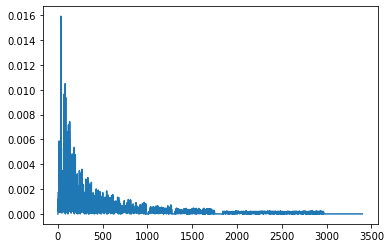

In [ ]:
plt.plot(y_p[0,:])

In [ ]:
ind_prob=np.where(y_p[0,:]>0.00600)[0]
ind_prob

array([ 32,  67,  81,  82,  86,  87, 109, 118, 131, 132])

In [ ]:
for i,ind in enumerate(ind_prob.tolist()):
  print(tokenizer3.index_word[ind], ' : ', y_p[0,i])

little  :  6.239563e-07
queen  :  0.0010834115
mock  :  0.00089746277
turtle  :  0.0011828063
hatter  :  0.00063289085
gryphon  :  0.0014486867
rabbit  :  0.0017662786
mouse  :  0.00095835555
duchess  :  0.00017775498
dormouse  :  0.0013121563


**Точность на тесте при различных гиперпараметрах:**

* 0.0862 - LTSM с длиной словаря 10000, шириной слоя LTSM 10
* 0.1024 - LTSM с длиной словаря 10000, шириной слоя LTSM 256
* 0.1494 - LTSM с длиной словаря 300, шириной слоя LTSM 10
* 0.0767 - LTSM с длиной словаря 100000, шириной слоя LTSM 10

На данном датасете увеличение ширины слоя или уменьшение длины словаря приводит к повышению точности на тесте.

# Задание 3*
Предложите свои варианты решения проблемы исчезающего градиента в RNN

## Решение

Для обучения RNN используется специальный вариант техники обратного распространения ошибки - по времени (Backpropogation Through Time, BPTT). Из-за этого имеется проблема исчезающего градиента в RNN. Во время обратного распространения ошибки обновление веса будет очень маленьким от слоя к слою, и в какой-то момент новый вес, который нужно добавить, станет равным старому весу, поэтому изменений нет, и обучение сети затруднено.

LSTM и GRU решают проблему исчезновения градиентов, так как у них есть внутренние механизмы, называемые ворота (gate), которые могут регулировать поток информации.

1. В LTSM:
* Ворота забывания (forget gate) решают, что следует сохранить от предыдущих шагов. 
* Входные ворота (input gate) решают, какую информацию добавить к текущему шагу. 
* Выходные ворота (output gate) определяют, каким должно быть следующее скрытое состояние.

2. В GRU  есть только два типа ворот:
* Ворота обновления (update gate) действуют аналогично воротам забывания и входным воротам в LSTM, они решают, какую информацию сохранить, а какую выбросить, и какую новую информацию добавить.
* Ворота сброса (reset gate) используются, чтобы решить, какую часть прошлой информации следует забыть.

С помощью вышеуказанных механизмов информация сохраняется для последующего использования, тем самым предотвращая постепенное затухание старых сигналов во время обработки.

